In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.preprocessing import MinMaxScaler


In [3]:
df = pd.read_csv('GMD.csv')

Variables to use: Country, year, rGDP_USD, imports_GDP, (Δ) governement debt, (Δ) M2, infl, unemp, cbrate, ltrate

In [4]:
api_key = 'e4bbbd109c546c1661986ae1b4815d17'  
fred = Fred(api_key=api_key)

# Dictionary of countries and their corresponding FRED series IDs for Consumer Confidence
consumer_confidence_series = {
    'Australia': 'CSCICP02AUM460S',
    'United Kingdom': 'CSCICP02GBM460S',
    'Japan': 'CSCICP02JPM460S',
    'Korea': 'CSCICP02KRA066S',
    'New Zealand': 'LOCOCIORNZQ665S',
    'United States': 'USALOCOCINOSTSAM',
    'Canada': 'CSCICP02CAM661N',  
    'Italy': 'CSCICP02ITM460S',
    'Portugal': 'CSCICP02PTM460S',
    'Turkey': 'CSCICP02TRM460S',
    'Brazil': 'CSCICP02BRM460S',
    'Czechia': 'CSCICP02CZM460S',
    'Switzerland': 'CSCICP02CHQ460S',
    'Germany': 'CSCICP02DEM460S',
    'France': 'CSCICP02FRM460S',
    'Mexico': 'CSCICP02MXM460S',
    'Russia': 'RUSCSCICP02STSAQ',
    'Spain': 'CSCICP02ESM460S',
    'Sweden': 'CSCICP02SEM460S',
    'Denmark': 'CSCICP02DKM460S',
    'Netherlands': 'CSCICP02NLM460S',  
    'China': 'CSCICP02CNM460S', 
}


data = {}
for country, series_id in consumer_confidence_series.items():
    data[country] = fred.get_series(series_id)
    
consumer_data = pd.DataFrame(data)

consumer_data_yearly = consumer_data.resample('YE').mean()

consumer_data_yearly.index = consumer_data_yearly.index.year

consumer_data_panel = consumer_data_yearly.reset_index().melt(id_vars='index', var_name='Country', value_name='Consumer_Confidence')
consumer_data_panel.rename(columns={'index': 'Year'}, inplace=True)

consumer_data_panel.dropna(inplace=True)




In [5]:
df_filtered = df[['countryname', 'year', 'rGDP_USD', 'imports_GDP', 'govdebt_GDP', 'M2', 'infl', 'unemp', 'cbrate', 'ltrate']]

df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
df_filtered['Δ_M2'] = df_filtered.groupby('countryname')['M2'].pct_change() * 100

/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_66392/2305044187.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_66392/2305044187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Δ_govdebt_GDP'] = df_filtered.groupby('countryname')['govdebt_GDP'].pct_change() * 100
/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_66392/2305044187.py:4: FutureWarn

In [6]:
df_filtered['Country'] = df_filtered['countryname']
df_filtered = df_filtered.drop('countryname', axis=1)

merged_df_before = pd.merge(df_filtered, consumer_data_panel, left_on=['year', 'Country'], right_on=['Year', 'Country'], how='inner')


/var/folders/ts/x847bxb170n3msnnpmdpjll00000gn/T/ipykernel_66392/2588897887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Country'] = df_filtered['countryname']


In [7]:
merged_df_before = merged_df_before.dropna()

In [8]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.05)
        Q3 = df[column].quantile(0.80)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

columns_to_check = ['Consumer_Confidence','infl','unemp','Δ_govdebt_GDP','Δ_M2']

merged_df = remove_outliers(merged_df_before, columns_to_check)

In [9]:
merged_df.dropna(inplace=True)
#merged_df.drop(['Year'], axis=1, inplace=True)
merged_df[merged_df['year'] <= 2019]

,year,rGDP_USD,imports_GDP,govdebt_GDP,M2,infl,unemp,cbrate,ltrate,Δ_govdebt_GDP,Δ_M2,Country,Year,Consumer_Confidence
1,1975,355049.81,14.711743,23.640409,3.194215e+04,15.162456,4.878655,8.400,9.741667,5.680190,20.559141,Australia,1975,5.250000
2,1976,368675.72,13.361888,22.985813,3.584829e+04,13.322886,4.749999,7.200,10.030833,-2.768971,12.228765,Australia,1976,7.416667
3,1977,374142.38,14.630217,23.642473,3.797083e+04,12.309813,5.604135,7.910,10.226666,2.856806,5.920916,Australia,1977,4.166667
4,1978,381696.06,14.570860,22.087608,4.195406e+04,8.004933,6.290086,8.280,9.060000,-6.576575,10.490239,Australia,1978,6.916667
5,1979,399204.50,15.335192,22.801823,4.682468e+04,9.122004,6.264902,8.000,9.749166,3.233555,11.609395,Australia,1979,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2015,18295000.00,15.277065,104.661000,1.177420e+07,0.118625,5.275000,0.375,2.135833,0.401949,5.905951,United States,2015,100.700151
777,2016,18627894.00,14.564439,106.582000,1.249080e+07,1.261581,4.875000,0.625,1.841667,1.835450,6.086188,United States,2016,99.750329
778,2017,19085692.00,14.947857,105.529000,1.328640e+07,2.136000,4.358000,1.375,2.330000,-0.987972,6.369488,United States,2017,100.358599
779,2018,19651900.00,15.158248,106.847000,1.386920e+07,2.440000,3.892000,2.375,2.910000,1.248946,4.386440,United States,2018,100.742298


In [10]:
merged_df.columns

Index(['year', 'rGDP_USD', 'imports_GDP', 'govdebt_GDP', 'M2', 'infl', 'unemp',
       'cbrate', 'ltrate', 'Δ_govdebt_GDP', 'Δ_M2', 'Country', 'Year',
       'Consumer_Confidence'],
      dtype='object')

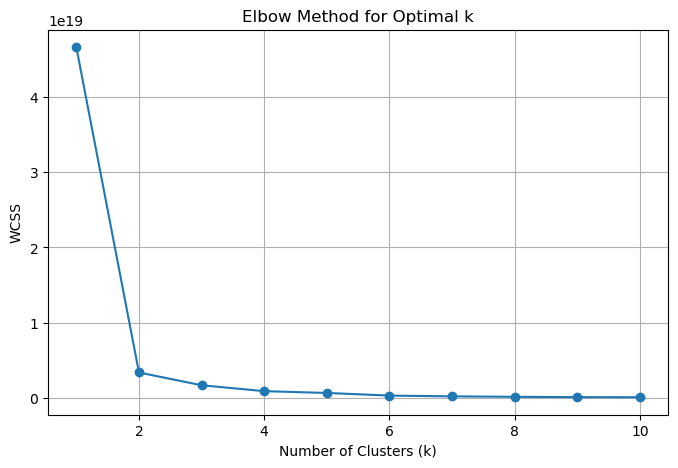

In [12]:
# Filter numeric columns and remove irrelevant ones
df_filtered_numeric = merged_df[['year', 'rGDP_USD', 'imports_GDP', 'govdebt_GDP', 'M2', 'infl', 'unemp',
       'cbrate', 'ltrate', 'Δ_govdebt_GDP', 'Δ_M2', 'Year',
       'Consumer_Confidence']]
df_filtered_numeric = df_filtered_numeric.drop(columns=['year', 'Year'], errors='ignore')
df_filtered_numeric = df_filtered_numeric.dropna()


from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_filtered_numeric)  # 'data' should be your normalized dataset
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Select features for clustering
X_kmeans = merged_df[['imports_GDP', 'Δ_govdebt_GDP', 'Δ_M2', 'unemp', 'cbrate', 'ltrate', 'rGDP_USD']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kmeans)

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
merged_df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)


In [14]:
# Group by clusters and calculate descriptive statistics for inflation
cluster_inflation_stats = merged_df.groupby('kmeans_cluster')['infl'].describe()

print(cluster_inflation_stats.round(2))
# Export the cluster inflation statistics as a CSV file
cluster_inflation_stats.to_csv("cluster_inflation_stats.csv", index=True)

                count  mean   std   min   25%   50%   75%    max
kmeans_cluster                                                  
0               216.0  1.91  1.67 -1.35  0.66  1.77  2.70   9.77
1               152.0  6.99  3.41  1.01  4.28  6.53  9.49  15.16
2               160.0  2.06  1.66 -1.14  1.00  1.92  2.62  10.22
3                47.0  2.57  1.45 -0.36  1.63  2.34  3.19   8.00


In [15]:
merged_df['infl_lagged'] = merged_df.groupby('Country')['infl'].shift(-2)
merged_df = merged_df.dropna(subset=['infl_lagged'])


In [16]:

#numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.difference(['year', 'Year','infl'])
#columns_to_normalize = merged_df[numeric_cols]

#scaler = StandardScaler()
#merged_df[numeric_cols] = scaler.fit_transform(columns_to_normalize)


In [48]:
merged_df

,year,rGDP_USD,imports_GDP,govdebt_GDP,M2,infl,unemp,cbrate,ltrate,Δ_govdebt_GDP,Δ_M2,Country,Year,Consumer_Confidence,kmeans_cluster,infl_lagged
1,1975,355049.81,14.711743,23.640409,3.194215e+04,15.162456,4.878655,8.400,9.741667,5.680190,20.559141,Australia,1975,5.250000,1,12.309813
2,1976,368675.72,13.361888,22.985813,3.584829e+04,13.322886,4.749999,7.200,10.030833,-2.768971,12.228765,Australia,1976,7.416667,1,8.004933
3,1977,374142.38,14.630217,23.642473,3.797083e+04,12.309813,5.604135,7.910,10.226666,2.856806,5.920916,Australia,1977,4.166667,1,9.122004
4,1978,381696.06,14.570860,22.087608,4.195406e+04,8.004933,6.290086,8.280,9.060000,-6.576575,10.490239,Australia,1978,6.916667,1,10.135841
5,1979,399204.50,15.335192,22.801823,4.682468e+04,9.122004,6.264902,8.000,9.749166,3.233555,11.609395,Australia,1979,0.583333,1,9.487668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,2017,19085692.00,14.947857,105.529000,1.328640e+07,2.136000,4.358000,1.375,2.330000,-0.987972,6.369488,United States,2017,100.358599,3,1.812000
779,2018,19651900.00,15.158248,106.847000,1.386920e+07,2.440000,3.892000,2.375,2.910000,1.248946,4.386440,United States,2018,100.742298,3,1.233584
780,2019,20159622.00,14.469283,108.004000,1.443270e+07,1.812000,3.675000,1.625,2.144167,1.082857,4.062960,United States,2019,101.032095,3,4.697859
781,2020,19723574.00,13.006123,131.830990,1.540130e+07,1.233584,8.092000,0.125,0.894167,22.061211,6.711149,United States,2020,98.982181,3,8.002800


<Figure size 1200x1000 with 0 Axes>

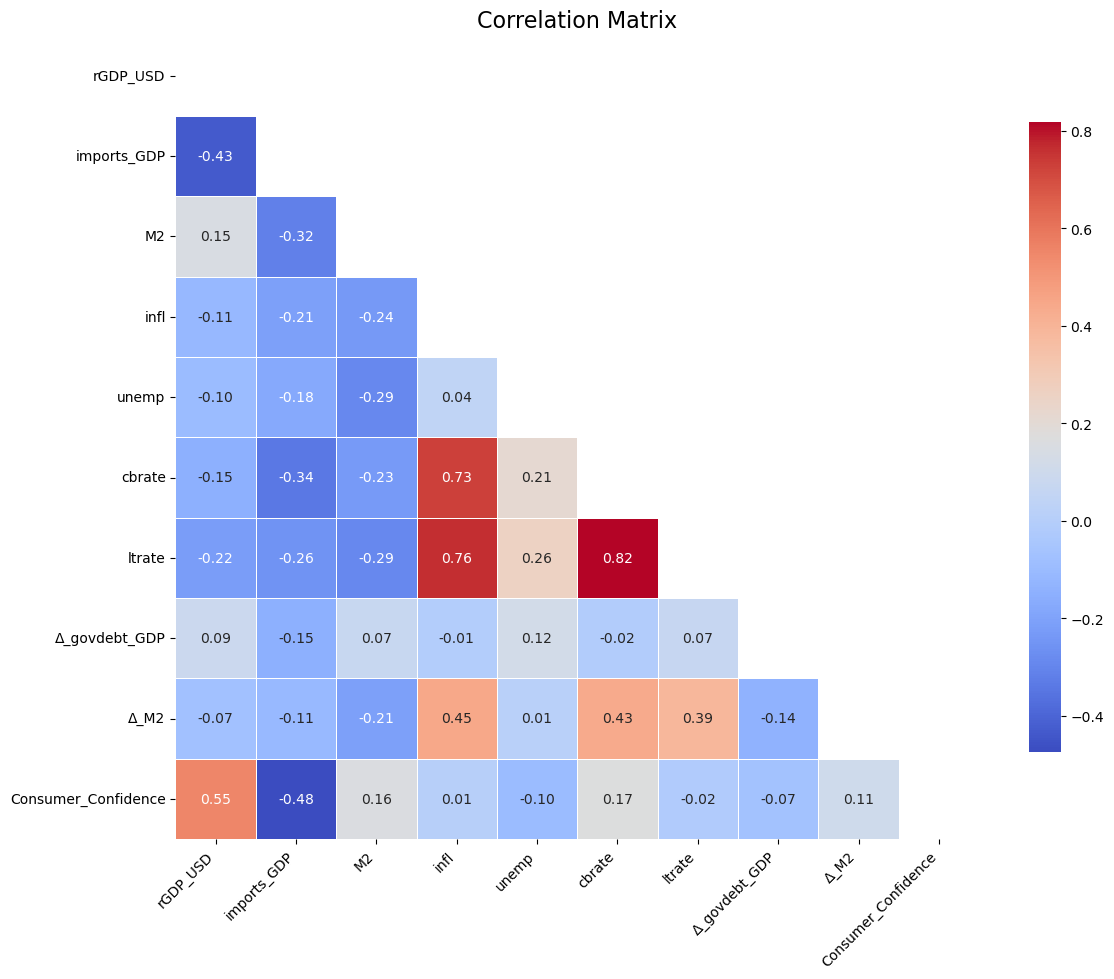

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))  # Bigger figure for clarity
df_corr = df_filtered_numeric.drop(columns=["govdebt_GDP"], errors='ignore')

corr = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    mask=np.triu(corr)
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



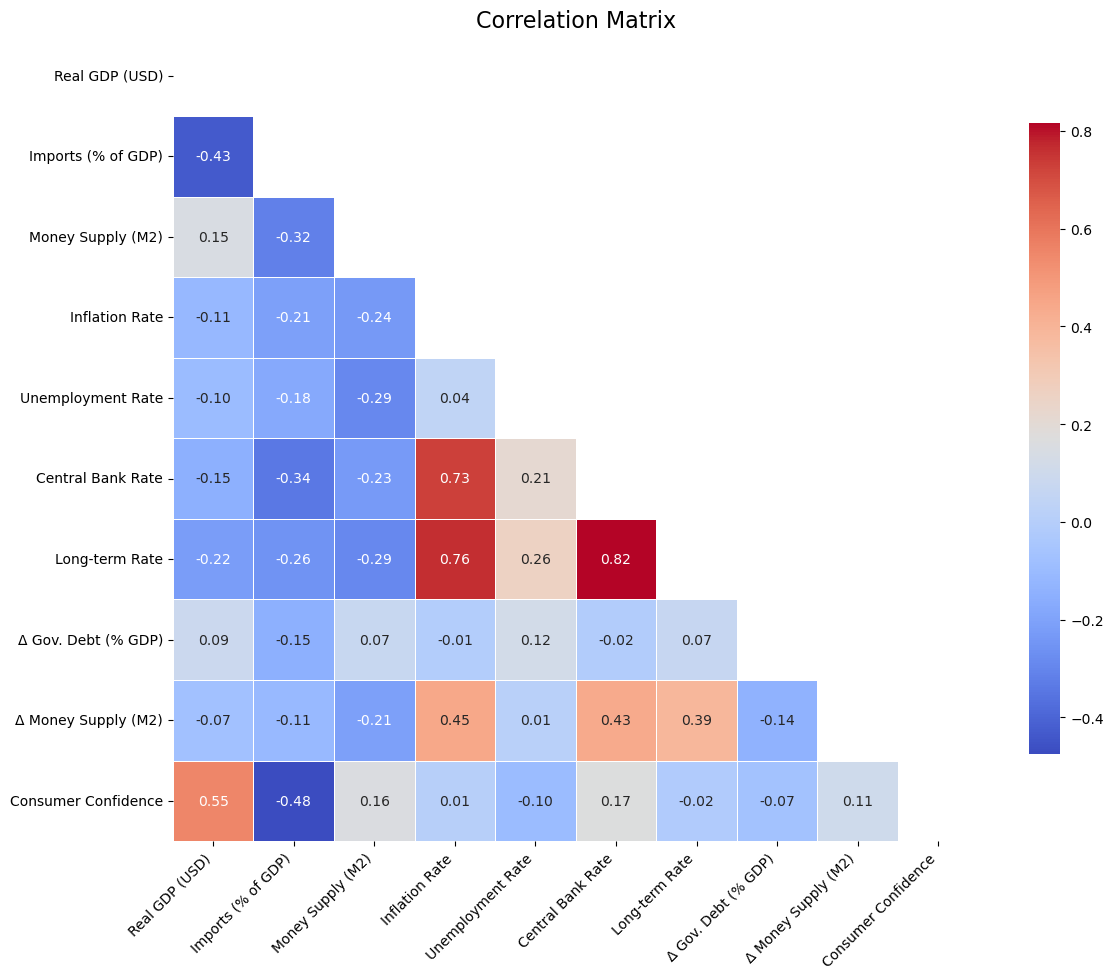

In [59]:
# Create a mapping of current column names to more readable labels
rename_dict = {
    "rGDP_USD": "Real GDP (USD)",
    "imports_GDP": "Imports (% of GDP)",
    "govdebt_GDP": "Gov. Debt (% of GDP)",
    "M2": "Money Supply (M2)",
    "infl": "Inflation Rate",
    "unemp": "Unemployment Rate",

    "cbrate": "Central Bank Rate",
    "ltrate": "Long-term Rate",
    "Δ_govdebt_GDP": "Δ Gov. Debt (% GDP)",
    "Δ_M2": "Δ Money Supply (M2)",
    "Consumer_Confidence": "Consumer Confidence",
    "kmeans_cluster": "Cluster (k-means)",
    "infl_lagged": "Lagged Inflation"
}

# Rename the columns and index for the correlation matrix
corr = df_filtered_numeric.corr()

corr.rename(index=rename_dict, columns=rename_dict, inplace=True)
corr = corr.drop(index="Gov. Debt (% of GDP)", columns="Gov. Debt (% of GDP)")

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    mask=np.triu(corr)
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Variables with over |.15| correlation --> Just for inital data exploration
rGDP & importsGDP --> Not surprising: more $, more imports
rGDP & govdebt -> Rich 'exceptionalism', those with bigger economies can afford debt
govdebt & LT_Rate, cbRate, infl --> Not Δ, but this could be important for FTPL
infl & cbrate, lt_rate --> adjusts for value, is expected
unemp & lt_rate --> Postive, expected, following phillips curve


To Do:
Identify Countries as developed or developing 

Identify if the information for consumer sentimenet is 'contained' within all other datapoints
    --> Indexed? Percent Change? normalization?

Scale all variables

Use KNN to determine bins
    --> before or after normalization?

In [19]:
descriptive_stats = df_filtered_numeric.describe()

In [20]:
df_filtered = merged_df
len(df_filtered)

537

In [21]:
merged_df.to_csv("Merged.csv")

In [22]:
merged_df_reset = merged_df.reset_index()
print(len(merged_df_reset))


537


In [23]:
df_filtered = df_filtered[df_filtered['year'] <= 2019]
len(df_filtered)

529

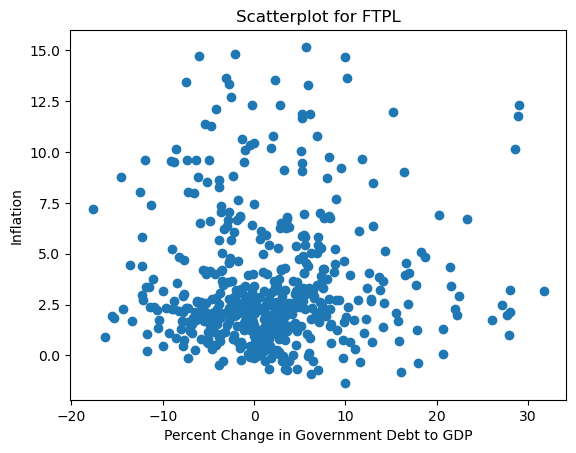

In [24]:
plt.scatter(df_filtered['Δ_govdebt_GDP'], df_filtered['infl'])
plt.xlabel('Percent Change in Government Debt to GDP')
plt.ylabel('Inflation')
plt.title('Scatterplot for FTPL')
plt.show()

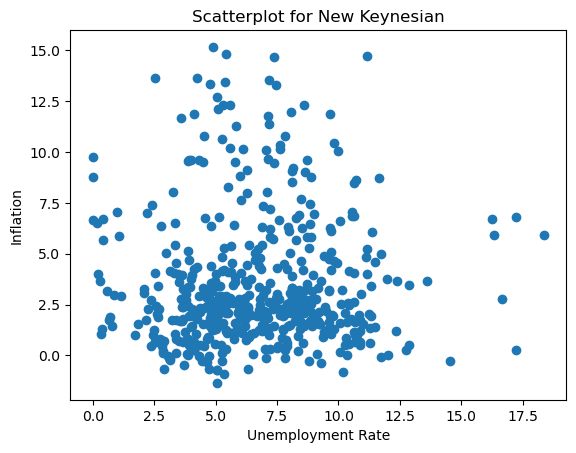

In [25]:
plt.scatter(df_filtered['unemp'], df_filtered['infl'])
plt.ylabel('Inflation')
plt.xlabel('Unemployment Rate')
plt.title('Scatterplot for New Keynesian')
plt.show()

## Hide


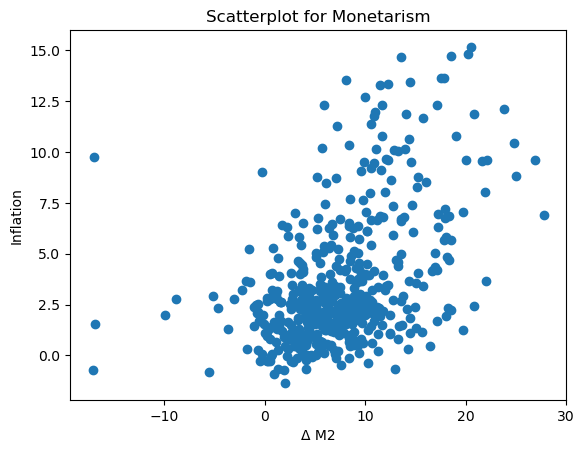

In [26]:
plt.scatter(df_filtered['Δ_M2'], df_filtered['infl'])   
plt.xlabel('Δ M2')
plt.ylabel('Inflation')
plt.title('Scatterplot for Monetarism')
plt.show()

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = df_filtered_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(df_filtered_numeric.values, i) for i in range(len(df_filtered_numeric.columns))]

vif_data

,Variable,VIF
0,rGDP_USD,2.517336
1,imports_GDP,4.079257
2,govdebt_GDP,10.459228
3,M2,3.344698
4,infl,6.571847
5,unemp,9.525442
6,cbrate,8.249773
7,ltrate,14.004026
8,Δ_govdebt_GDP,1.166654
9,Δ_M2,3.571008


# Regression to determine 'Information Inclusion' of Consumer Sentiment

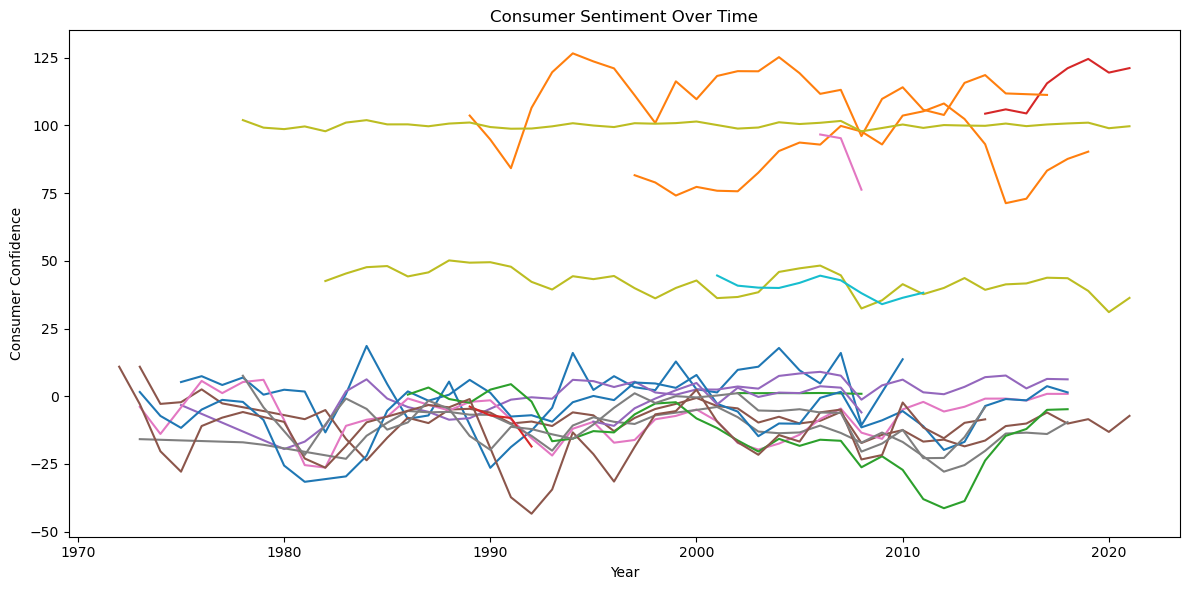

In [28]:
plt.figure(figsize=(12, 6))
for country in merged_df['Country'].unique():
    country_data = merged_df[merged_df['Country'] == country]
    plt.plot(country_data['Year'], country_data['Consumer_Confidence'], label=country)

plt.xlabel('Year')
plt.ylabel('Consumer Confidence')
plt.title('Consumer Sentiment Over Time')
plt.tight_layout()
plt.show()

Conclusion: Don't have nearly enough information, could try another way, bt I think that this is a good baseline.

# Causal Forest

In [29]:
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

In [30]:
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
import os
import pandas as pd
import urllib.request
from sklearn.preprocessing import StandardScaler

In [31]:
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

In [32]:
merged_df = merged_df.dropna()

In [33]:
merged_df['year'].unique()

array([1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2010, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 1989, 1973, 1974, 1972])

In [34]:
n_trees = 1000
min_leaf_size = 50
max_depth = 20
subsample_ratio = 0.04

#Y = merged_df['infl']
Y = merged_df['infl_lagged']
T1 = merged_df['unemp']
T2 = merged_df['Δ_govdebt_GDP']
T3 = merged_df['Δ_M2']
scaler = StandardScaler()

W1 = scaler.fit_transform(merged_df[['Δ_govdebt_GDP','Δ_M2','cbrate','ltrate']])
X1 = merged_df[['Consumer_Confidence','imports_GDP','rGDP_USD','kmeans_cluster']]

W2 = scaler.fit_transform(merged_df[['unemp','Δ_M2','cbrate','ltrate']])
X2 = merged_df[['Consumer_Confidence','imports_GDP','rGDP_USD','kmeans_cluster']]


W3 = scaler.fit_transform(merged_df[['unemp','Δ_govdebt_GDP','cbrate','ltrate']])
X3 = merged_df[['Consumer_Confidence','imports_GDP','rGDP_USD','kmeans_cluster' ]]


est = CausalForestDML(model_y=WeightedLassoCVWrapper(cv=3, n_jobs=-1, random_state=123),
                        model_t=WeightedLasso(alpha=0.01),
                        discrete_treatment=False,
                        n_estimators=n_trees,
                        min_samples_leaf=min_leaf_size,
                        max_depth=max_depth,
                        random_state=123)

In [35]:
NK_Tree = est.fit(Y,T1,X=X1, W=W1)
FTPL_Tree = est.fit(Y,T2,X=X2, W=W2)
M_Tree = est.fit(Y, T3, X=X3, W=W3)




Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x314943950> has a non-default cv attribute, which will be ignored
Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x16d63a5d0> has a non-default cv attribute, which will be ignored
Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x31522e410> has a non-default cv attribute, which will be ignored


In [36]:
NK_Tree.feature_importances_

array([0.081, 0.777, 0.14 , 0.002])

In [37]:
def run_causal_forest(Y, T, X, W, W_cols, title):
    est = CausalForestDML(
        model_y=WeightedLassoCVWrapper(cv=3, n_jobs=-1, random_state=123),
        model_t=WeightedLasso(alpha=0.01),
        discrete_treatment=False,
        n_estimators=n_trees,
        min_samples_leaf=min_leaf_size,
        max_depth=max_depth,
        random_state=123,
    )

    est.fit(Y, T, X=X, W=W)
    
    ate = est.effect(X).mean()
    print(f"\nEstimated ATE ({title}): {ate:.4f}")
    
    return est, ate


In [38]:
est_NK, NK_CATE = run_causal_forest(Y, T1, X1, W1,
    W_cols=['imports_GDP','cbrate','ltrate',  'rGDP_USD' ,'Consumer_Confidence','kmeans_cluster'],
    title='New Keynesian (T = unemp)'
)

est_FTPL, FTPL_CATE = run_causal_forest(Y, T2, X2, W2,
    W_cols=['imports_GDP','cbrate','ltrate', 'rGDP_USD' ,'Consumer_Confidence', 'kmeans_cluster'],
    title='Fiscal Theory of Price Level (T = Δ_govdebt_GDP)'
)

est_M, M_CATE = run_causal_forest(Y, T3, X3, W3,
    W_cols=['imports_GDP','cbrate','ltrate', 'rGDP_USD' ,'Consumer_Confidence','kmeans_cluster'],
    title='Monetarist (T = Δ_M2)'
)


Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x175db29d0> has a non-default cv attribute, which will be ignored



Estimated ATE (New Keynesian (T = unemp)): -0.1362


Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x175d66510> has a non-default cv attribute, which will be ignored



Estimated ATE (Fiscal Theory of Price Level (T = Δ_govdebt_GDP)): -0.0002


Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x315491050> has a non-default cv attribute, which will be ignored



Estimated ATE (Monetarist (T = Δ_M2)): 0.1278


In [39]:
import matplotlib.pyplot as plt



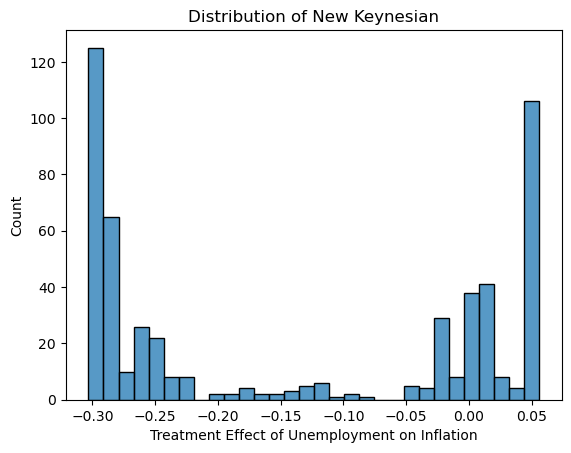

In [40]:
individual_effects = est_NK.effect(X1)

import seaborn as sns
sns.histplot(individual_effects, bins=30)
plt.title("Distribution of New Keynesian")
plt.xlabel("Treatment Effect of Unemployment on Inflation")
plt.show()


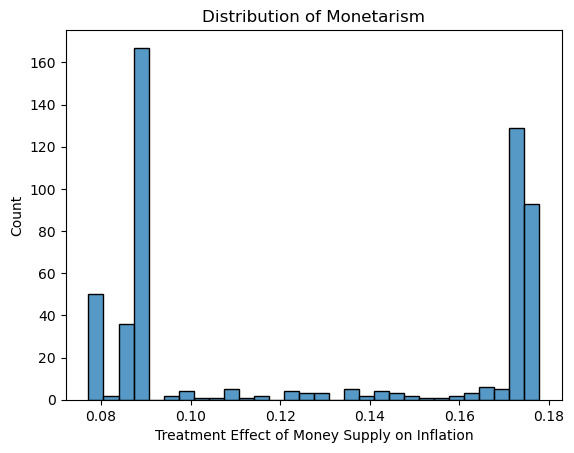

In [41]:
individual_effects = est_M.effect(X2)

import seaborn as sns
sns.histplot(individual_effects, bins=30)
plt.title("Distribution of Monetarism")
plt.xlabel("Treatment Effect of Money Supply on Inflation")
plt.show()


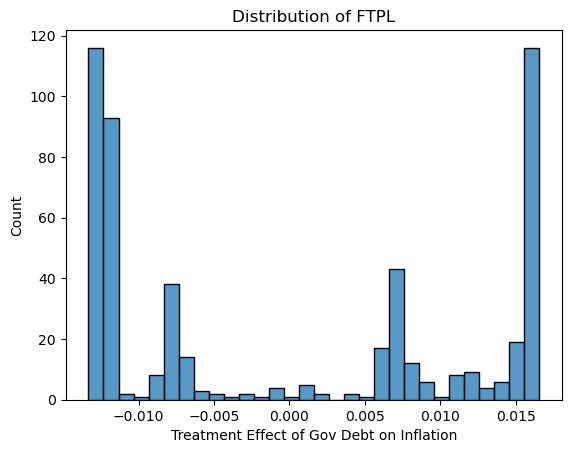

In [42]:
individual_effects = est_FTPL.effect(X3)

import seaborn as sns
sns.histplot(individual_effects, bins=30)
plt.title("Distribution of FTPL")
plt.xlabel("Treatment Effect of Gov Debt on Inflation")
plt.show()


In [43]:
def run_causal_forest(Y, T, X, W, W_cols, title):
    est = CausalForestDML(
        model_y=WeightedLassoCVWrapper(cv=3, n_jobs=-1, random_state=123),
        model_t=WeightedLasso(alpha=0.01),
        discrete_treatment=False,
        n_estimators=n_trees,
        min_samples_leaf=min_leaf_size,
        max_depth=max_depth,
        random_state=123
    )

    est.fit(Y, T, X=X, W=W)
    
    ate = est.effect(X).mean()
    ci_lower_array, ci_upper_array = est.effect_interval(X)
    ci_lower = ci_lower_array.mean()
    ci_upper = ci_upper_array.mean()
    
 
    fi_x = est.feature_importances_[:X.shape[1]]
    fi_w = est.feature_importances_[X.shape[1]:]
    print(fi_w)
    print("Break")
    print(f"{title}")
    print(f"Estimated ATE: {ate:.4f}")
    print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    
    return {
        'title': title,
        'ate': ate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'fi_x': fi_x,
        'fi_w': fi_w,
        'X_cols': list(X.columns),
        'W_cols': W_cols
    }


In [44]:
results = []

results.append(run_causal_forest(Y, T1, X1, W1,
    W_cols=['Δ_govdebt_GDP','Δ_M2','cbrate', 'ltrate'],
    title='Unemployment'
))

results.append(run_causal_forest(Y, T2, X2, W2,
    W_cols=['unemp','Δ_M2','cbrate', 'ltrate'],
    title='% Δ_govdebt_GDP'
))

results.append(run_causal_forest(Y, T3, X3, W3,
    W_cols=['unemp','Δ_govdebt_GDP','cbrate', 'ltrate'],
    title='% Δ_M2'
))


Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x316c60bd0> has a non-default cv attribute, which will be ignored


[]
Break
Unemployment
Estimated ATE: -0.1362
95% CI: [-0.2443, -0.0280]


Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x31ce0b950> has a non-default cv attribute, which will be ignored


[]
Break
% Δ_govdebt_GDP
Estimated ATE: -0.0002
95% CI: [-0.0455, 0.0450]


Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x31ce39310> has a non-default cv attribute, which will be ignored


[]
Break
% Δ_M2
Estimated ATE: 0.1278
95% CI: [0.0587, 0.1970]


In [45]:
results

[{'title': 'Unemployment',
  'ate': -0.13618092465582246,
  'ci_lower': -0.24432012462071728,
  'ci_upper': -0.028041724690927725,
  'fi_x': array([0.084, 0.754, 0.161, 0.001]),
  'fi_w': array([], dtype=float64),
  'X_cols': ['Consumer_Confidence',
   'imports_GDP',
   'rGDP_USD',
   'kmeans_cluster'],
  'W_cols': ['Δ_govdebt_GDP', 'Δ_M2', 'cbrate', 'ltrate']},
 {'title': '% Δ_govdebt_GDP',
  'ate': -0.0002488382804201445,
  'ci_lower': -0.045516119964999574,
  'ci_upper': 0.045018443404159274,
  'fi_x': array([0.084, 0.696, 0.218, 0.002]),
  'fi_w': array([], dtype=float64),
  'X_cols': ['Consumer_Confidence',
   'imports_GDP',
   'rGDP_USD',
   'kmeans_cluster'],
  'W_cols': ['unemp', 'Δ_M2', 'cbrate', 'ltrate']},
 {'title': '% Δ_M2',
  'ate': 0.1278494479820339,
  'ci_lower': 0.05865534700232063,
  'ci_upper': 0.19704354896174717,
  'fi_x': array([0.081, 0.777, 0.14 , 0.002]),
  'fi_w': array([], dtype=float64),
  'X_cols': ['Consumer_Confidence',
   'imports_GDP',
   'rGDP_USD',
 

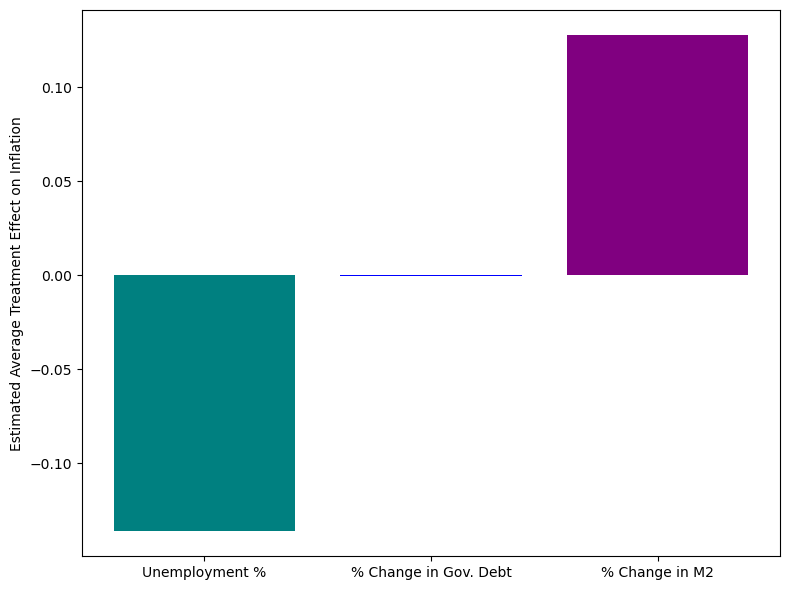

In [46]:
model_names = ["Unemployment %", "% Change in Gov. Debt", "% Change in M2"]  
ates = [res['ate'] for res in results]

plt.figure(figsize=(8, 6))
plt.bar(model_names, ates, color = ['Teal', 'Blue', 'Purple'])
plt.ylabel('Estimated Average Treatment Effect on Inflation')
#plt.title('Comparing Theories of Inflation: ATE Estimates')
plt.tight_layout()
plt.show()

In [94]:
results

[{'title': 'Unemployment',
  'ate': -0.135269795981918,
  'ci_lower': -0.2680170584878791,
  'ci_upper': -0.0025225334759568004,
  'fi_x': array([0.09309309, 0.68168168, 0.13513514, 0.09009009]),
  'fi_w': array([], dtype=float64),
  'X_cols': ['Consumer_Confidence',
   'imports_GDP',
   'rGDP_USD',
   'kmeans_cluster'],
  'W_cols': ['Δ_govdebt_GDP', 'Δ_M2', 'cbrate', 'ltrate']},
 {'title': '% Δ_govdebt_GDP',
  'ate': -0.004076863624289372,
  'ci_lower': -0.04104670290219316,
  'ci_upper': 0.03289297565361441,
  'fi_x': array([0.1031031 , 0.59359359, 0.15915916, 0.14414414]),
  'fi_w': array([], dtype=float64),
  'X_cols': ['Consumer_Confidence',
   'imports_GDP',
   'rGDP_USD',
   'kmeans_cluster'],
  'W_cols': ['unemp', 'Δ_M2', 'cbrate', 'ltrate']},
 {'title': '% Δ_M2',
  'ate': 0.10547433672795567,
  'ci_lower': 0.027782959376049254,
  'ci_upper': 0.1831657140798621,
  'fi_x': array([0.08108108, 0.58358358, 0.1981982 , 0.13713714]),
  'fi_w': array([], dtype=float64),
  'X_cols': ['

In [95]:
summary_df = pd.DataFrame([{
    'Model': res['title'],
    'ATE': res['ate'],
    'Lower': res['ci_lower'],
    'Upper': res['ci_upper'],
} for res in results])

display(summary_df.round(4))


,Model,ATE,Lower,Upper
0,Unemployment,-0.1353,-0.2680,-0.0025
1,% Δ_govdebt_GDP,-0.0041,-0.0410,0.0329
2,% Δ_M2,0.1055,0.0278,0.1832


In [96]:
for res in results:
    print(f"\nFeature Importances for {res['title']}")
    
    print("X Heterogeneity features:")
    for col, imp in zip(res['X_cols'], res['fi_x']):
        print(f"  {col}: {imp:.4f}")
    
    print("W Control variables:")
    for col, imp in zip(res['W_cols'], res['fi_w']):
        print(f"  {col}: {imp:.4f}")



Feature Importances for Unemployment
X Heterogeneity features:
  Consumer_Confidence: 0.0931
  imports_GDP: 0.6817
  rGDP_USD: 0.1351
  kmeans_cluster: 0.0901
W Control variables:

Feature Importances for % Δ_govdebt_GDP
X Heterogeneity features:
  Consumer_Confidence: 0.1031
  imports_GDP: 0.5936
  rGDP_USD: 0.1592
  kmeans_cluster: 0.1441
W Control variables:

Feature Importances for % Δ_M2
X Heterogeneity features:
  Consumer_Confidence: 0.0811
  imports_GDP: 0.5836
  rGDP_USD: 0.1982
  kmeans_cluster: 0.1371
W Control variables:


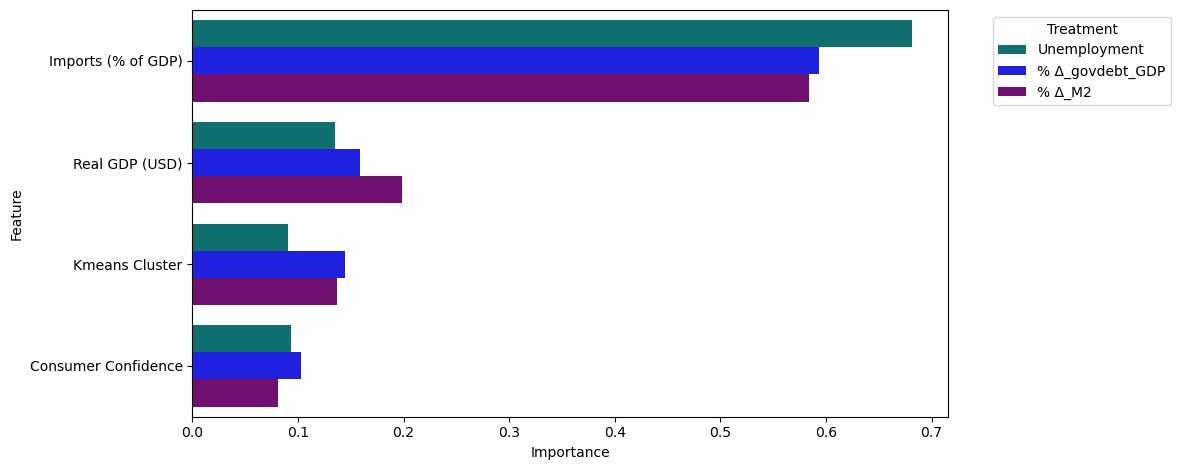

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

x_rows = []
for res in results:
    title = res['title']
    for col, imp in zip(res['X_cols'], res['fi_x']):
        x_rows.append({'Model': title, 'Variable': col, 'Importance': imp})

fi_df = pd.DataFrame(x_rows)

# Map for renaming variables
variable_name_map = {
    'rGDP_USD': 'Real GDP (USD)',
    'imports_GDP': 'Imports (% of GDP)',
    'Δ_govdebt_GDP': ' % Change in (Gov Debt / GDP)',
    'Δ_M2': 'Change in Money Supply (M2)',
    'Consumer_Confidence': 'Consumer Confidence',
    'kmeans_cluster' : 'Kmeans Cluster'
}

fi_df['Variable'] = fi_df['Variable'].replace(variable_name_map)
fi_df = fi_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(12, 0.4 * len(fi_df)))

barplot = sns.barplot(
    data=fi_df,
    y="Variable",
    x="Importance",
    hue="Model",
    palette=["Teal","Blue", "Purple"]  
)

#plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.legend(title="Treatment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [98]:
results[0]

{'title': 'Unemployment',
 'ate': -0.135269795981918,
 'ci_lower': -0.2680170584878791,
 'ci_upper': -0.0025225334759568004,
 'fi_x': array([0.09309309, 0.68168168, 0.13513514, 0.09009009]),
 'fi_w': array([], dtype=float64),
 'X_cols': ['Consumer_Confidence',
  'imports_GDP',
  'rGDP_USD',
  'kmeans_cluster'],
 'W_cols': ['Δ_govdebt_GDP', 'Δ_M2', 'cbrate', 'ltrate']}

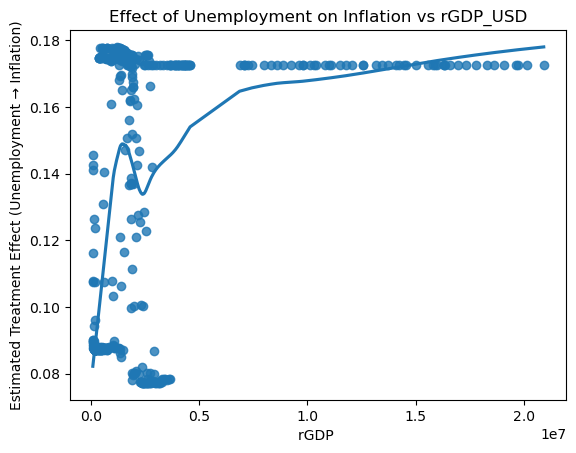

In [47]:

treatment_effects = est.effect(X1)

plot_df = pd.DataFrame({
    'rGDP_USD': X1['rGDP_USD'],
    'Treatment_Effect': treatment_effects
})

# Plot
sns.regplot(x='rGDP_USD', y='Treatment_Effect', data=plot_df, lowess=True)
plt.title("Effect of Unemployment on Inflation vs rGDP_USD")
plt.xlabel("rGDP ")
plt.ylabel("Estimated Treatment Effect (Unemployment → Inflation)")
plt.show()


In [51]:
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def run_causal_forest(Y, T, X, W, W_cols, title, n_trees=100, min_leaf_size=10, max_depth=None):
    est = CausalForestDML(
        model_y=WeightedLassoCVWrapper(cv=3, n_jobs=-1, random_state=123),
        model_t=WeightedLasso(alpha=0.01),
        discrete_treatment=False,
        n_estimators=n_trees,
        min_samples_leaf=min_leaf_size,
        max_depth=max_depth,
        random_state=123
    )

    est.fit(Y, T, X=X, W=W)

    # Estimate ATE and confidence interval
    ate = est.effect(X).mean()
    ci_lower_array, ci_upper_array = est.effect_interval(X)
    ci_lower = ci_lower_array.mean()
    ci_upper = ci_upper_array.mean()

    # Feature importances
    fi_x = est.feature_importances_[:X.shape[1]]
    fi_w = est.feature_importances_[X.shape[1]:]

    # Display
    print("Model complete.")
    print("Feature importances (W):", fi_w)
    print("Break")
    print(title)
    print(f"Estimated ATE: {ate:.4f}")
    print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]\n")

    return {
        'title': title,
        'ate': ate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'feature_importances_X': fi_x,
        'feature_importances_W': fi_w,
        'X_cols': list(X.columns),
        'W_cols': W_cols
    }


In [52]:
results = []

results.append(run_causal_forest(Y, T1, X1, W1,
    W_cols=['Δ_govdebt_GDP','Δ_M2','cbrate', 'ltrate'],
    title='Unemployment'
))

results.append(run_causal_forest(Y, T2, X2, W2,
    W_cols=['unemp','Δ_M2','cbrate', 'ltrate'],
    title='% Δ_govdebt_GDP'
))

results.append(run_causal_forest(Y, T3, X3, W3,
    W_cols=['unemp','Δ_govdebt_GDP','cbrate', 'ltrate'],
    title='% Δ_M2'
))


Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x30d986f90> has a non-default cv attribute, which will be ignored


Model complete.
Feature importances (W): []
Break
Unemployment
Estimated ATE: -0.1426
95% CI: [-0.3652, 0.0801]



Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x30cc4fb90> has a non-default cv attribute, which will be ignored


Model complete.
Feature importances (W): []
Break
% Δ_govdebt_GDP
Estimated ATE: -0.0028
95% CI: [-0.0605, 0.0548]



Model <econml.sklearn_extensions.linear_model.WeightedLassoCVWrapper object at 0x30ec08110> has a non-default cv attribute, which will be ignored


Model complete.
Feature importances (W): []
Break
% Δ_M2
Estimated ATE: 0.0976
95% CI: [0.0166, 0.1787]



In [53]:
import pandas as pd

summary_df = pd.DataFrame([{
    'Model': r['title'],
    'ATE': r['ate'],
    '95% CI Lower': r['ci_lower'],
    '95% CI Upper': r['ci_upper']
} for r in results])

print(summary_df)


             Model       ATE  95% CI Lower  95% CI Upper
0     Unemployment -0.142554     -0.365241      0.080132
1  % Δ_govdebt_GDP -0.002822     -0.060464      0.054820
2           % Δ_M2  0.097638      0.016570      0.178706
